<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-equipo175-rva-a01378921-rrm-a01793108/blob/main/reto-parte2/notebook/TrabajoParte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

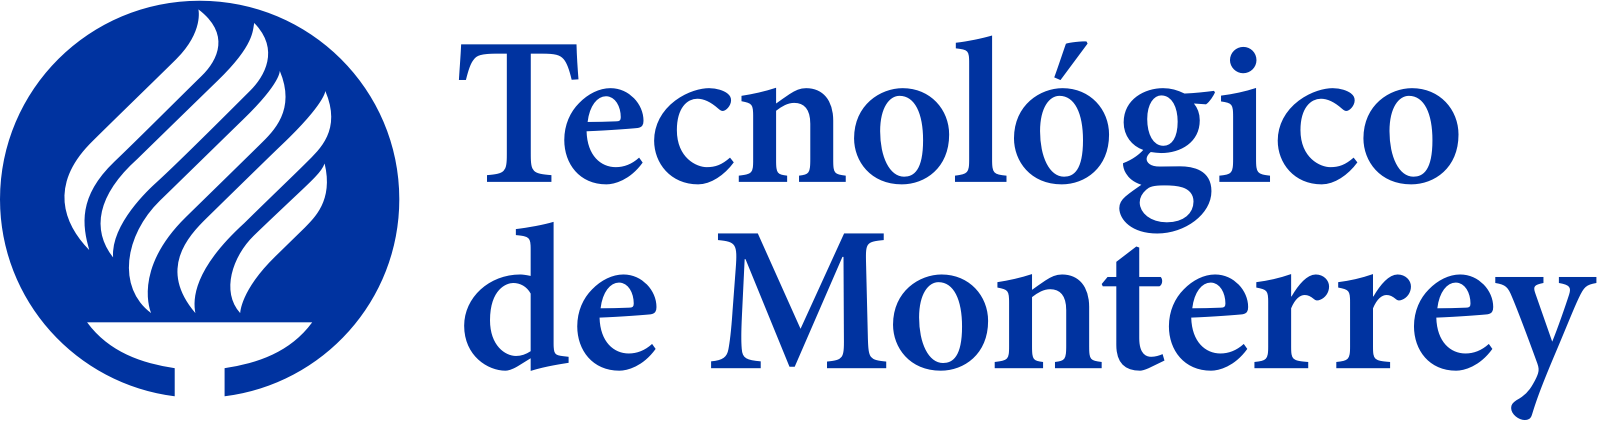

Materia: Ciencia y analítica de datos

Nombre de la actividad: ***Semana 9: Reto (Parte 2) Clasificación-ensambles y presentación ejecutiva (10 diapositivas max)***

Nombre de los alumnos:
* Ricardo Jonahthan Robayo
* Roberto Vega Alanis

Matrículas: 
* A01793108
* A01378921

Docente: Dra. María de la Paz Rico Fernández

Fecha: 15 de Noviembre de 2022

In [2]:
# Librerías

## Para manipulación de datos estructurados
import pandas as pd 
import numpy as np

## Para visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt

## Para hacer las particiones
from sklearn.model_selection import train_test_split

# Modelos a utilizar
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Curvas de aprendizaje y validación
from sklearn.model_selection import learning_curve, validation_curve

# GridSearch
from sklearn.model_selection import GridSearchCV

# Impresión árbol
from sklearn import tree

# Elementos para las métricas
from sklearn.metrics import confusion_matrix         
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import  cross_validate,  RepeatedStratifiedKFold

In [ ]:
# Establecemos la paráetro en pandas que nos permite visualizar todas las columnas
pd.set_option('max_column',None)

In [ ]:
# Omitimos los warnings de scikitlearn
import warnings
warnings.filterwarnings("ignore")

Del notebook anterior se extrae el conjunto de datos ya preprocesado. 
Se decide separar el entrenamiento de modelos en un notebook individual con el fin de poder gestionar mejorar el uso de recursos computacionales de Colab.

En el poeprocesamiento ya se han llevado los siguientes procesos:
* Limpieza de los datos
* Correcta determinació de tipo de dato para cada variable
* Eliminación de las variables de nula utilidad (eliminación de clases unitarias, eliminación de valores numéricos excesivamente sesgados)
* Codificación numérica jerarquizada de variables ordinales categóricas (funsión euivalente a gapminder)
* Codificación numérica de variables categóricas booleanas (OneHotEncoding con drop_first, sustitución equivalente)
* Escalamiento de variables numéricas (MinMaxScaler)

# 0. Ingesta de los datos

In [1]:
# Liga donde se contiene la fuente de datos preprocesada
url = 'https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-equipo175-rva-a01378921-rrm-a01793108/main/reto-parte2/dataset/df_sub_clean.csv'

In [3]:
# Ingesta del csv
df_sub_clean = pd.read_csv(url)

In [5]:
# Análisis de clase
df_sub_clean['SEMAFORO'].value_counts(normalize = True)

2    0.405123
0    0.362429
1    0.232448
Name: SEMAFORO, dtype: float64

Podemos observar que si bien llega a haberun ligero desbalenco entre las clases, este no es severo. Por lo tanto, es porbable que con el uso de pesos en las clases ala hora del entrenamiento del modelo se puedan sobrellevar

# 1. Selecciona tus variables independientes X y dependiente Y (semáforo)

Creamos un conjunto (DataFrame) de datos con las variables independientes (predictoras). Creamos un DataFrame de una sola columna con la variable objetivo (y).

In [ ]:
# Selección de variables independientes (predictoras) y dependiente (objetivo)
y = df_sub_clean['SEMAFORO']
X = df_sub_clean.drop(columns = 'SEMAFORO', axis = 1).iloc[:,1:]

X

,LONGITUD,LATITUD,ALC_mg/L,CALIDAD_ALC,CONDUCT_mS/cm,CALIDAD_CONDUC,SDT_M_mg/L,CALIDAD_SDT_ra,CALIDAD_SDT_salin,FLUORUROS_mg/L,CALIDAD_FLUO,DUR_mg/L,CALIDAD_DUR,CALIDAD_COLI_FEC,N_NO3_mg/L,CALIDAD_N_NO3,CALIDAD_AS,CALIDAD_CD,CALIDAD_CR,CALIDAD_HG,CALIDAD_PB,CALIDAD_MN,CALIDAD_FE,CUMPLE_CON_ALC,CUMPLE_CON_COND,CUMPLE_CON_SDT_ra,CUMPLE_CON_SDT_salin,CUMPLE_CON_FLUO,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,0.491345,0.422140,0.125265,3,0.044945,2,0.006122,3,3,0.022420,2,0.050621,1,4,0.034416,2,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0.485350,0.410587,0.126497,3,0.026967,3,0.004194,4,3,0.021068,2,0.043051,1,4,0.047355,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0.482422,0.430860,0.109822,3,0.022852,3,0.002934,4,3,0.046346,3,0.026071,1,4,0.011811,2,0,1,1,1,1,2,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1
3,0.482205,0.420786,0.185024,3,0.031191,3,0.004599,4,3,0.026648,2,0.046965,1,4,0.010231,2,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0.215417,0.490724,0.174481,3,0.093735,2,0.013133,2,2,0.000968,0,0.120105,1,2,0.129365,0,2,1,1,1,1,2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,0.574573,0.562977,0.125915,3,0.121297,1,0.017602,2,2,0.000000,0,0.192717,0,4,0.120630,0,2,1,1,1,1,2,1,1,0,1,1,1,0,1,0,1,1,1,1,1,1,1
1050,0.569234,0.564216,0.141287,3,0.022689,3,0.002386,4,3,0.000000,0,0.066264,1,4,0.639500,0,2,1,1,1,1,2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
1051,0.565157,0.606672,0.187297,3,0.134835,1,0.021589,2,2,0.016086,2,0.168465,0,2,0.301324,0,2,1,1,1,1,2,1,1,0,1,1,1,0,1,0,1,1,1,1,1,1,1
1052,0.548233,0.565230,0.102565,3,0.041317,2,0.007183,3,3,0.014739,2,0.101465,1,4,0.000000,2,2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# 2. Cambia a label encoding el semáforo, ej, de ["clase 1", "clase 2", "clase 3"] a [ 1,2,3]

Esta categorización ya se ha realizado en la preparación de los datos, sin embargo, la escala seleccionada fue Verde = 2, Amarillo = 1, Rojo = 0.
Debido a que la categorización y escalamiento de otras variables se ralizó a partir de 0, se decide mantener la codificación prestablecida.

# 3. Realiza tu clasificador, recuerda dividir los datos de manera balanceada (auxiliate de train test split) 

In [ ]:
# hacemos separación de los datos
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 100, stratify = y)

Aplicamos el parámetro de stratify = y para propiciar la mejora del desempeño del modelo. Se le puede considerar como data leakage, sin embargo, debido la naturaleza de los datos no genera un problema de sobrentrenamiento.

# 4. Explora que clasificador es el más optimo, ejemplo: Decision trees Random Forest. 

Creación de los modelos

In [ ]:
def get_models():
  modelos = list()
  nombres = list()

  # DT - Árbol de Decisión:
  modelos.append(DecisionTreeClassifier())
  nombres.append('Árbol de Decisión')
  
  # RF - Árbol de Decisión:
  modelos.append(RandomForestClassifier())
  nombres.append('Bosque Aleatorio')

  return modelos, nombres

In [ ]:
# Parámetros
modelos, nombres = get_models()  # cargamos los modelos a comparar
resultados = list()

## Árbol de decisión

In [ ]:
# Decision tree
modelos[0]

DecisionTreeClassifier()

In [ ]:
# Creamos un Fold para combiunaciones
mi_kfold = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state= 7)

Debido a que una única prueba con una sola distribución del conjunto de valores de prueba es sumamente ineficiente y no demuestra la correcata generalización del modelo a los datos, se decie realizar GridSearch con validación cruzada incrustada. Hacemos uso del fold estratificado por ser el mejor para creación de modelos de clasificación.

In [ ]:
# Árbol de decisión

# Definir param grid con lista de parametros a incluir en el gridsearch
param_grid = [
  {'criterion': ['gini','entropy'],
  'ccp_alpha': [0.1, 0.2, 0.4, 0.7, 0.01],
  'class_weight': ['balanced',None],
  'max_depth':[2, 4, 6, 8, 12, 16],
  'min_samples_split':[5, 10, 15, 20, 30, 50]
  }
 ]

#Definir grid search con scoring mi_precision y el mismo cv definido en pasos anteriores
grid_dt = GridSearchCV(modelos[0], param_grid = param_grid,  cv = mi_kfold, return_train_score = True )

grid_dt.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=7),
             estimator=DecisionTreeClassifier(),
             param_grid=[{'ccp_alpha': [0.1, 0.2, 0.4, 0.7, 0.01],
                          'class_weight': ['balanced', None],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 4, 6, 8, 12, 16],
                          'min_samples_split': [5, 10, 15, 20, 30, 50]}],
             return_train_score=True)

In [ ]:
# Mejor combinación de parámetros obtenidos
grid_dt.best_params_

{'ccp_alpha': 0.01,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 12,
 'min_samples_split': 5}

In [ ]:
# Mejor desempeño (score) obtenido con la métrica “precisión”
grid_dt.best_score_

0.9553183995491686

Se obtienen los parámetros del modelo que brindaron el mejor desempeño. Así mismo, se observa el nivel de accuracy obtenido para el mismo (es el promedio de los accuracys obtenidos en la validación cruzada para dicha configuración de parámetros).

## Bosque Aleatorio

Se realiza un procedimiento similar al seguido para el caso de árbol de decisión para desarrllar el modelo de Bosque Aleatorio.

In [ ]:
# Bosque aleatorio
modelos[1]

RandomForestClassifier()

In [ ]:
# Parametros para GridSearchCV
# Los hiperparámetros que debes incluir en su búsqueda deben ser al menos los siguientes: ccp_alpha, criterion, max_depth, min_samples_split y class_weight
param_grid = {'criterion': ['gini','entropy'],
             'ccp_alpha': [0.001, 0.01, 1.0],
             'class_weight': ['balanced',None],
             'max_depth':np.linspace(1,6,6),
             'min_samples_split':[5, 10, 15]
             }

# Aplicamos GridSearchCV a Rfc
#CV_rfc = GridSearchCV(estimator=est, param_grid=param_grid, cv= 5)
grid_rfc = GridSearchCV (estimator =  modelos[1], 
                       param_grid = param_grid,
                       cv = mi_kfold,
                       n_jobs = -1)

grid_rfc.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=7),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.001, 0.01, 1.0],
                         'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([1., 2., 3., 4., 5., 6.]),
                         'min_samples_split': [5, 10, 15]})

In [ ]:
# Mejor combinación de parámetros obtenidos
grid_rfc.best_params_

{'ccp_alpha': 0.001,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 6.0,
 'min_samples_split': 5}

In [ ]:
# Mejor desempeño (score) obtenido con la métrica “recall”
grid_rfc.best_score_

0.9588757396449703

Obsrvamos que la mejora en el accuracy promedio con respecto al modelo de árbol de decisón solo mejora en un 0.3%, una medida despreciable si se compara con el incremento en el teimpo de entrenamiento. El entrenamientto por medio de GridSearch para modelo de árbol de decisión tomó alrededor de 1 minuto, mientras que l modelo de bosque aleatorio tomó alrededor de 9 minutos.

# 5. Determina el grado de exactitud a través del reporte de clasificación

## Árboles de decisión

### Reporte con valores de entrenamiento

In [ ]:
# Reporte de clasificación
cr_dt_train = classification_report(y_train, grid_dt.best_estimator_.predict(X_train))
print(cr_dt_train)

              precision    recall  f1-score   support

           0       0.99      0.92      0.96       306
           1       0.90      0.99      0.94       196
           2       1.00      1.00      1.00       341

    accuracy                           0.97       843
   macro avg       0.96      0.97      0.97       843
weighted avg       0.97      0.97      0.97       843



### Reporte de valores de prueba

In [ ]:
# Reporte de clasificación
cr_dt_test = classification_report(y_test, grid_dt.best_estimator_.predict(X_test))
print(cr_dt_test)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        76
           1       0.90      0.96      0.93        49
           2       1.00      1.00      1.00        86

    accuracy                           0.97       211
   macro avg       0.96      0.96      0.96       211
weighted avg       0.97      0.97      0.97       211



Se puede observar cómo el modelo llega a tener un desmpeño ligeramente menor en el conjunto de prueba en comparación con el desempeño en el conjunto de entrenamiento, esto es una buena señal ya qu enos indica que es poco probable que exista sobre entrenamiento. Por otra parte, podemos notar que los scores tanto para precision, recall, accuracy y f1 son superiores al 90% para ambos conjuntos de datos, con lo cual se puede decir que s eobtuvo uin buen modelo con un adecuado nievl de complejidad (y por lo tanto, no presenta sub entrenamiento).

Cabe resaltar que, al tener un desbalanceo en los datos las medidas más adecuadas deberían ser aquells que consideran tanto a los Falsos positivos como a los falso snegativos, es por ello que nos enfocamos en f1-score, mismo que, de ser necesario pdría ser afectado por pesos para poder obtener una mejor visualización del desempeño de la calsificación.

## Bosque Aletorio

### Reporte con valores de entrenamiento

In [ ]:
# Reporte de clasificación
cr_rfc_train = classification_report(y_train, grid_rfc.best_estimator_.predict(X_train))
print(cr_rfc_train)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       306
           1       0.96      0.96      0.96       196
           2       0.96      1.00      0.98       341

    accuracy                           0.97       843
   macro avg       0.97      0.97      0.97       843
weighted avg       0.97      0.97      0.97       843



### Reporte de valores de prueba

In [ ]:
# Reporte de clasificación
cr_rfc_test = classification_report(y_test, grid_rfc.best_estimator_.predict(X_test))
print(cr_rfc_test)

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        76
           1       0.92      0.94      0.93        49
           2       0.96      1.00      0.98        86

    accuracy                           0.96       211
   macro avg       0.96      0.96      0.96       211
weighted avg       0.96      0.96      0.96       211



Con respecto al modelo de bosuqe aleatorio, podemos observar que tiene un desempeño muy similr al de árbol decisión, llegando a tener en algunas iteraciones de algunas métricas deseméños mejores entre un 1% y un 3%.

Adicionalmente, se observa que el modelo no ae en el sobreentrenamiento extremo ya que solo en un par de ocasiones se llega  tener un desempeño del 100%, lo cual indica que si bien el modelo tiene un buen desempeño, no memoriza los valores de entrenamiento del todo, sino es capaz de generalizar.

# 6. Visualiza los resultados del modelo o las predicciones a través de una matriz de confusión.

Creamos una función para el despliegue del mapa de calor para cada matriz de cnfusión solicitada.

Se decide crear 4 matrices 2 para cada modlo en donde se prueba el desempeño tanto sobre el conjunto de entrenamiento como de prueba.

In [ ]:
# Función para formato de Heatmap de matriz de confusión
def cm_plot(cm):
  frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
  porcentaje = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]

  labels = [f"{v2}\n{v3}" for v2, v3 in zip(frecuencia,porcentaje)]
  labels = np.asarray(labels).reshape(3,3)

  ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
  ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
  plt.show()

## Árbol de decisión

### Matriz con valores de entrenamiento

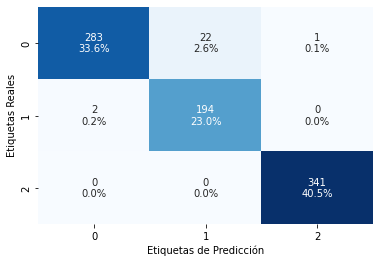

In [ ]:
# Matriz de confusión
cm_dt_train = confusion_matrix(y_train, grid_dt.best_estimator_.predict(X_train))
cm_plot(cm_dt_train)

### Matriz con valores de prueba

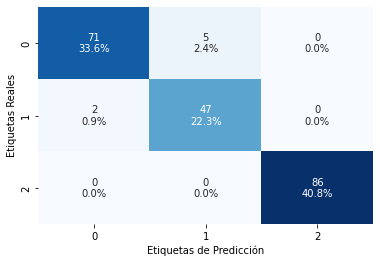

In [ ]:
# Matriz de confusión
cm_dt_test = confusion_matrix(y_test, grid_dt.best_estimator_.predict(X_test))
cm_plot(cm_dt_test)

Para este modelo, se muestra una tendencia semjante para ambos conjuntos de datos. A pesar de que la clase mayoritaria (con mayor número de muestras) sea la clase 0 (Roja), no se muestra un sesgo importante del resto de las clases sobre esta. Es decir, no tenemos un modelo demasiado simple que se decante por asignar la mayor cantidad de puntos hacia dicha clase, en su defecto se obsertva la mayor cantidad de errores en los falsos positivos de la clase 2 (Amarilla). Esto no indica que le modelo suele tender a ser un poco optimista en sus predicciones llegando a asignar como regular la calidad del agua cuando en relidad podría llegar a ser mala, sin embargo, esta categoización no es en extrema negativa pues no llega a catalogar los datos de la clase Amarilla (1) ni Roja (0) en la clase Verde (2). A pesar de ello, sería importante buscar mejorar el modelo buscando hacerlo más estricto, eviitando catalogar valores Amarillos en Rojo, ya que estos casos pueden llegar a ser extremadamete dañinos para la salud.

## Bosuqe Aleatorio

### Matriz con valores de entrenamiento

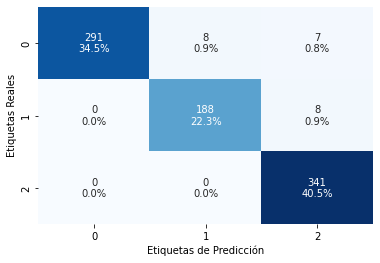

In [ ]:
# Matriz de confusión
cm_rfc_train = confusion_matrix(y_train, grid_rfc.best_estimator_.predict(X_train))
cm_plot(cm_rfc_train)

### Matriz con valores de prueba

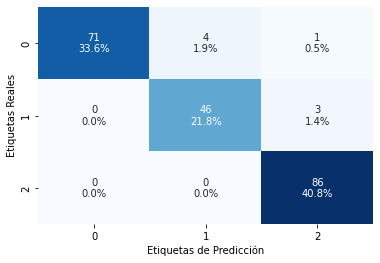

In [ ]:
# Matriz de confusión
cm_rfc_test = confusion_matrix(y_test, grid_rfc.best_estimator_.predict(X_test))
cm_plot(cm_rfc_test)

Para el caso del modelo de bosque aleatorio, a pesar de que su métrica de accuracy inicial así como su reporte de clasificación no mostraba mayor diferencia, se puede observar en la matriz de confusión una notable diferencia ya que el caso de Falsos negativos para la calse roja se diminuye de manera considerable (en un 50% aproximadamente), esto lleva a determinar a este modelo como el ideal para su aplicación al reducir el riesgo de catalogar de manera optmista la calidad del agua de peor calidad.

# 7. Realiza un análisis general de las features importances a traves de decision trees o random forest. 

# Árbol de decisión

Feature: 0, LONGITUD, Score: 0.00000
Feature: 1, LATITUD, Score: 0.01163
Feature: 2, ALC_mg/L, Score: 0.00000
Feature: 3, CALIDAD_ALC, Score: 0.00000
Feature: 4, CONDUCT_mS/cm, Score: 0.05824
Feature: 5, CALIDAD_CONDUC, Score: 0.00000
Feature: 6, SDT_M_mg/L, Score: 0.00000
Feature: 7, CALIDAD_SDT_ra, Score: 0.00000
Feature: 8, CALIDAD_SDT_salin, Score: 0.00000
Feature: 9, FLUORUROS_mg/L, Score: 0.00000
Feature: 10, CALIDAD_FLUO, Score: 0.19941
Feature: 11, DUR_mg/L, Score: 0.00000
Feature: 12, CALIDAD_DUR, Score: 0.00000
Feature: 13, CALIDAD_COLI_FEC, Score: 0.01329
Feature: 14, N_NO3_mg/L, Score: 0.03476
Feature: 15, CALIDAD_N_NO3, Score: 0.00000
Feature: 16, CALIDAD_AS, Score: 0.01317
Feature: 17, CALIDAD_CD, Score: 0.00000
Feature: 18, CALIDAD_CR, Score: 0.01115
Feature: 19, CALIDAD_HG, Score: 0.00000
Feature: 20, CALIDAD_PB, Score: 0.00522
Feature: 21, CALIDAD_MN, Score: 0.05706
Feature: 22, CALIDAD_FE, Score: 0.07770
Feature: 23, CUMPLE_CON_ALC, Score: 0.03072
Feature: 24, CUMPLE_

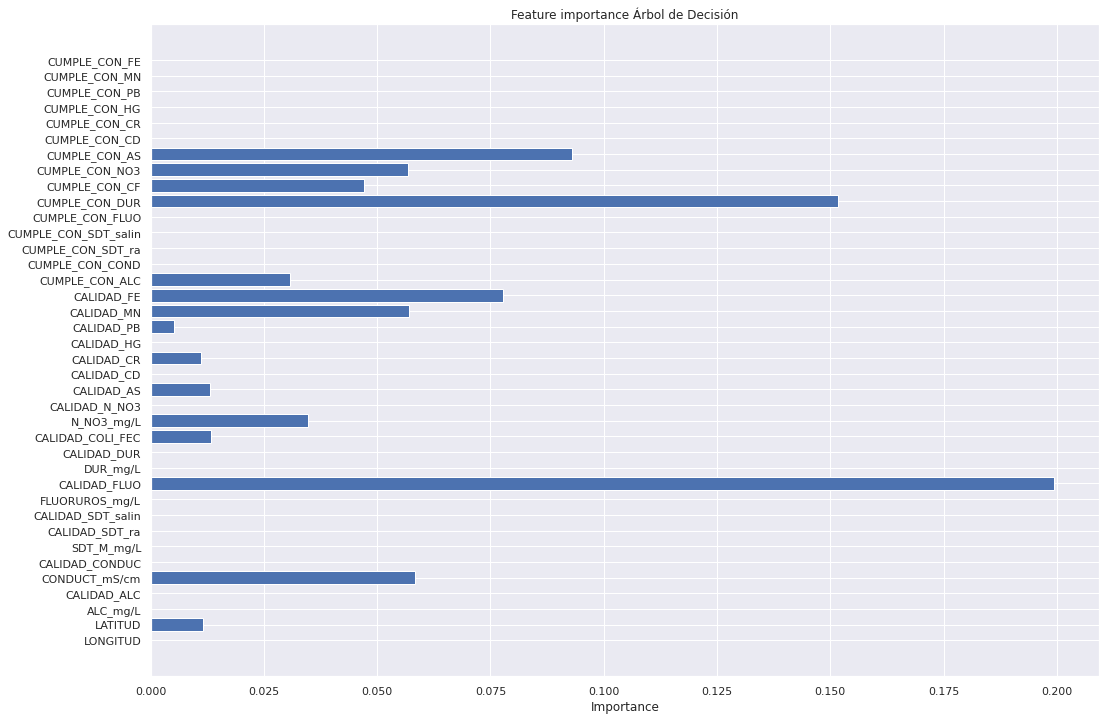

In [ ]:
# Para análisis de importancia de factores
from sklearn.inspection import permutation_importance

importance = permutation_importance(grid_dt.best_estimator_, X_train, y_train, n_repeats=10)

# visualicemos la importancia de cada métrica, de las cuales sabemos
# cuáles son las más importantes, de acuerdo a como se definieron al inicio:

for i,v in enumerate(importance['importances_mean']):
	print('Feature: %0d, %s, Score: %.5f' % (i,X_train.columns[i],v))

#fig, ax = plt.subplots(figsize = (20,20))
sns.set(rc={'figure.figsize':(17,12)})
plt.barh(X_train.columns, importance['importances_mean'])
plt.title('Feature importance Árbol de Decisión')
plt.xlabel('Importance')
plt.show()

Podemos observar que existe una cantidad reducida de variables qcuya importancia parec nula para el modelo. Esto se puede deber en cierta medida ala simpleza del modelo ya que las variables conimporancia llegan a tener valores relativamente altos.

## Bosque Aleatorio

Feature: 0, LONGITUD, Score: 0.00451
Feature: 1, LATITUD, Score: 0.00522
Feature: 2, ALC_mg/L, Score: 0.00391
Feature: 3, CALIDAD_ALC, Score: 0.00059
Feature: 4, CONDUCT_mS/cm, Score: 0.00913
Feature: 5, CALIDAD_CONDUC, Score: 0.00344
Feature: 6, SDT_M_mg/L, Score: 0.00451
Feature: 7, CALIDAD_SDT_ra, Score: 0.00249
Feature: 8, CALIDAD_SDT_salin, Score: 0.00119
Feature: 9, FLUORUROS_mg/L, Score: 0.00925
Feature: 10, CALIDAD_FLUO, Score: 0.00083
Feature: 11, DUR_mg/L, Score: 0.00925
Feature: 12, CALIDAD_DUR, Score: 0.00439
Feature: 13, CALIDAD_COLI_FEC, Score: 0.03488
Feature: 14, N_NO3_mg/L, Score: -0.00178
Feature: 15, CALIDAD_N_NO3, Score: 0.00142
Feature: 16, CALIDAD_AS, Score: 0.02776
Feature: 17, CALIDAD_CD, Score: 0.00000
Feature: 18, CALIDAD_CR, Score: 0.00474
Feature: 19, CALIDAD_HG, Score: 0.00000
Feature: 20, CALIDAD_PB, Score: 0.00237
Feature: 21, CALIDAD_MN, Score: 0.02123
Feature: 22, CALIDAD_FE, Score: 0.02681
Feature: 23, CUMPLE_CON_ALC, Score: 0.00142
Feature: 24, CUMPLE

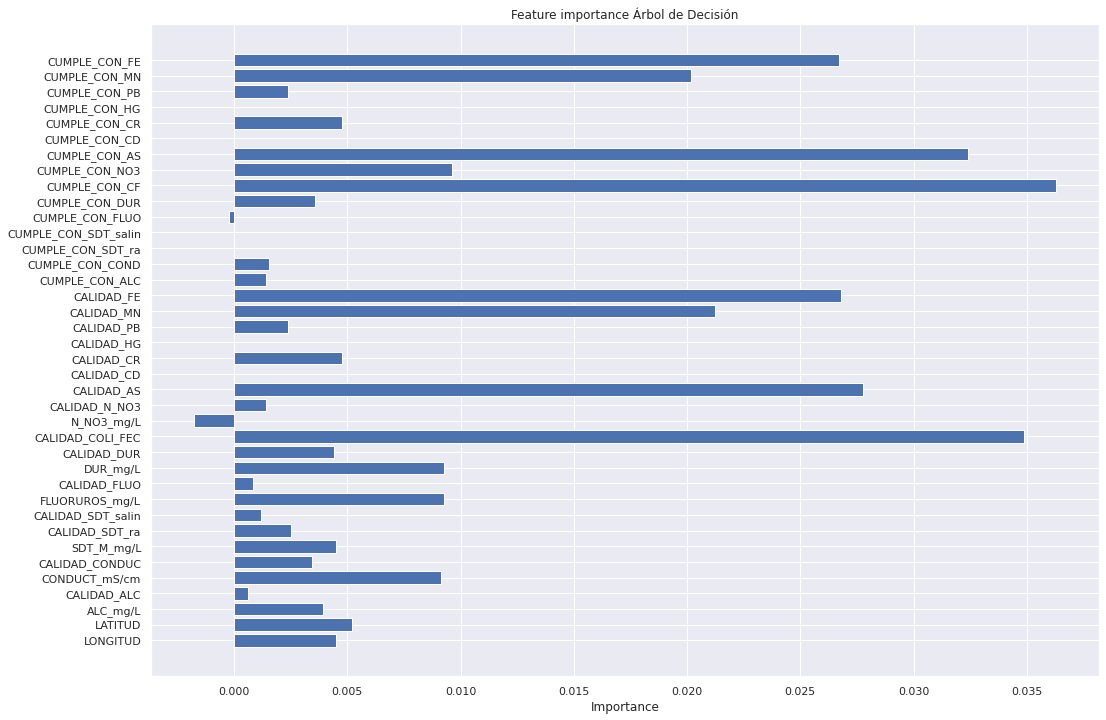

In [ ]:
# Para análisis de importancia de factores
from sklearn.inspection import permutation_importance

importance = permutation_importance(grid_rfc.best_estimator_, X_train, y_train, n_repeats=10)

# visualicemos la importancia de cada métrica, de las cuales sabemos
# cuáles son las más importantes, de acuerdo a como se definieron al inicio:

for i,v in enumerate(importance['importances_mean']):
	print('Feature: %0d, %s, Score: %.5f' % (i,X_train.columns[i],v))

#fig, ax = plt.subplots(figsize = (20,20))
sns.set(rc={'figure.figsize':(17,12)})
plt.barh(X_train.columns, importance['importances_mean'])
plt.title('Feature importance Árbol de Decisión')
plt.xlabel('Importance')
plt.show()

A diferencia del modelo anterior, se puede observar que existe un conjunto de variables con valores negativos, esto puede indicar un sesgo indeseado por parte de las mismas. Así mismo, se observa en comparación con el modelo anterior que se brinda mayor importancaa mayor cantidad de variables, sejando muy pocas con valor igual a 0.

# Conclusión

Con base en el análisis realizado se llega a las siguientes conclusiones. 

En primer lugar, con respecto al preprocesamiento del conjunto
es interesante como la asignación de una categoría dentro de un campo eminentemente numérico puede llegar a dificultar el procesamiento de los datos como lo fue el caso de todas las variables numéricas. Adicionalmente, pudimos observar que, a pesar de que existían variables numéricas y categóricas ordinales que se correlacionaban su mantenimiento ayudó en gran medida al buen desempeño del modelo brindando más información las categóricas ordinales. Esto probablemente se debió al sesgo generalizado de los límites inferiores. Por su parte, el análisis de las variables categóricas mostró una dificultad particular al mostrar la necesidad de no perder la jerarquización de las clases en su codificación, ya que de haber optado por un OneHot encoding en todas las variables, probablemente gran parte del desempeño se habría perdido, con l cual se concluye que es necesaria la codificación numérica jerarquizada para clases ordinales. Por otro lado, con respecto a las variables numéricas, se llegó a la conclusión de que debido la notoria diferencia de rangos entre las distintas variables y su efecto en la visualización de las mismas, las variables numéricas deben ser escaladas para su introducción a modelos predictivos.

Con respecto al análisis de K means, después de la realización de muy diversas pruebas, se pudo observar que no existía una categorización consistente de las clases dela variable objetivo a nivel geográfico, llevándonos a concluir que probablemente el factor geográfico no tengo relevancia suficiente para la determinación de la calidad del agua, al menos no de manera determinante.

Por otra parte, con respecto a la comparación en el desempeño de los modelo, se puede llegar a pensar en primera instancia que el modelo más simple (árbol de decisión) es el mejor ya que presenta métricas muy similares al modelo complejo (bosque aleatorio), sin embargo, al tomar en consideración los resultados de la matriz de confusión y las implicaciones reales de los errores obtenidos, se concluye que el mejor modelo es el bosque aleatorio porque a pesar de ser más complejo brinda los mejores resultados al reducir considerablemente los casos de falsos negativos para la clase de mala calidad (Roja) aumentando la confiabilidad y seguridad del modelo ya que es esencial reducir al mínimo los casos en lo que el modelo determine una muestra como regular o buena cuando esta es mala por las implicaciones a la salud que este error podría implicar; esto sin llegar a caer en el sobre entrenamiento, siendo que el desempeño del modelo no es perfecto y no dista mucho entre sus métricas de las predicciones del mismo sobre los 2 conjuntos de datos utilizados (entrenamiento y prueba). Adicionalmente, al hacer uso de validación cruzada se asegura que el modelo tiene una buena capacidad generalización, es decir, que es capaz de brindar buenas clasificaciones para diferentes tipos de muestra.

Por último, con respecto al grado de importancia de las variables, se puede observar de manera general que las variables de mayor importancia son las variables categóricas, siendo repartidas entre las de clase "CUMPLE" y "CALIDAD", teniendo una importancia predominante de métrica de coliformes fecales, un resultado que era de esperarse. Seguido de esta variable se muestran en siguiente nivel de importancia el valor de "flúor" y lo que parecen ser los metales pesados en el agua, mismos que para ser enunciados requeriríamos la metadata de los mismos. Adicionalmente, se observa que las variables de latitud y longitud no llegan a tener una importancia considerable para ninguno de los modelos, esto es consistente con el análisis previo de K means, en donde no se mostraba una clusterización consistente de la distribución de la calidad del agua subterránea. Con lo anterior, sería posible eliminar las variables consideradas de nula importancia y re-entrenar el modelo incrementando el número de iteraciones del mismo con el fin de buscar un mayor c¿grado de precisión y exactitud del modelo.


# 8. Realiza un reporte de los principales hallazgos y conclusiones del experimento e incluyelos en una presentación ejecutiva de 10 diapositivas. La presentación deberá incluir todos los pasos del pipeline seguidos, limpieza, análisis, kmeans, clasificación, resultados y conclusiones.

Esta sección estará contenida en un archivo independiente par presentación. El cual resumirá todo el anpalisis expuesto a lo largo de los 2 noteboks desarrolados.